In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

In [3]:
data = pd.read_csv('processed_airbnb_data_ML.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469754 entries, 0 to 469753
Data columns (total 49 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Host Since                   469754 non-null  object 
 1   Host Response Time           469754 non-null  object 
 2   Neighbourhood Cleansed       469754 non-null  object 
 3   City                         469754 non-null  object 
 4   State                        469748 non-null  object 
 5   Country                      469754 non-null  object 
 6   Property Type                469754 non-null  object 
 7   Room Type                    469754 non-null  object 
 8   Accommodates                 469754 non-null  float64
 9   Bathrooms                    469754 non-null  float64
 10  Bedrooms                     469754 non-null  float64
 11  Beds                         469754 non-null  float64
 12  Bed Type                     469754 non-null  object 
 13 

Price Skewness (before log): 2.890299930157411
Price Skewness (after log): 0.5043948902368507


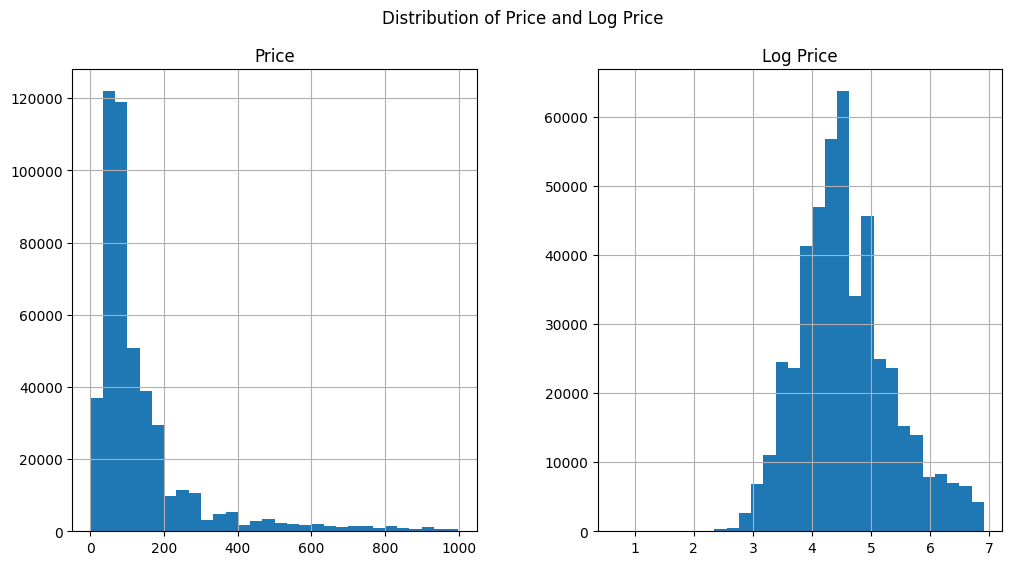

In [6]:
# Check skewness of prices
print("Price Skewness (before log):", data['Price'].skew())

# Apply log transformation to the 'Price' column
data['Log Price'] = np.log1p(data['Price'])  # Use log1p to handle zero prices safely

# Check skewness after log transformation
print("Price Skewness (after log):", data['Log Price'].skew())

# Histogram to compare distributions
data[['Price', 'Log Price']].hist(bins=30, figsize=(12, 6), layout=(1, 2))
plt.suptitle("Distribution of Price and Log Price")
plt.show()

In [7]:
# Filter dataset for listings in the United States
us_data = data[data['Country'] == 'United States']

# Save the filtered dataset to a new CSV file
us_data.to_csv('us_listings.csv', index=False)

# Print the first few rows to verify
print(us_data.head())

     Host Since  Host Response Time Neighbourhood Cleansed            City  \
885  2014-11-22       Not Specified         Woodland Hills     los angeles   
886  2016-02-02        within a day         Woodland Hills     los angeles   
887  2016-11-22  within a few hours         Woodland Hills     los angeles   
888  2015-01-03      within an hour         Woodland Hills     los angeles   
889  2014-08-08       Not Specified         Woodland Hills  woodland hills   

    State        Country Property Type        Room Type  Accommodates  \
885    ca  United States     Apartment     Private room           2.0   
886    ca  United States         House  Entire home/apt           8.0   
887    ca  United States    Guesthouse  Entire home/apt           3.0   
888    ca  United States     Townhouse  Entire home/apt           6.0   
889    ca  United States         House     Private room           2.0   

     Bathrooms  ...  Response Rate Category  Has Info about Host  \
885        1.0  ...     

In [8]:
# Define features and target variable
features = [
    'Property Type', 'Room Type', 'City',
    'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type',
    'Guests Included', 'Is there Security Deposit',
    'Is there Cleaning Fee', 'Has Notes', 'Has Amenities',
    'Is Capital', 'Is Short Term', 'Charges for Extra People',
    'House Rules Length', 'House Rules Category', 'Response Rate Category',
    'Has Info about Host',
    'Description Length',
]

target = 'Log Price'

# Separate features and target
X = us_data[features]
y = us_data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Categorical and numerical transformations
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = StandardScaler()

# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define pipeline with linear regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print evaluation metrics
print("Training Metrics:")
print(f"Mean Squared Error: {train_mse:.2f}")
print(f"R^2 Score: {train_r2:.2f}\n")

print("Test Metrics:")
print(f"Mean Squared Error: {test_mse:.2f}")
print(f"R^2 Score: {test_r2:.2f}\n")

# Print feature coefficients
if hasattr(pipeline['regressor'], 'coef_'):
    # Get feature names
    feature_names = numeric_features.tolist() + list(
        pipeline.named_steps['preprocessor']
        .named_transformers_['cat']
        .get_feature_names_out(categorical_features)
    )
    coefficients = pipeline.named_steps['regressor'].coef_

    print("Feature Coefficients:")
    for feature, coef in zip(feature_names, coefficients):
        print(f"{feature}: {coef:.4f}")

Training Metrics:
Mean Squared Error: 0.19
R^2 Score: 0.61

Test Metrics:
Mean Squared Error: 0.19
R^2 Score: 0.61

Feature Coefficients:
Accommodates: 0.1760
Bathrooms: 0.0688
Bedrooms: 0.1216
Beds: -0.0388
Guests Included: 0.0327
Is there Security Deposit: -0.0003
Is there Cleaning Fee: -0.0051
Has Notes: -0.0089
Has Amenities: -0.0158
Is Capital: 0.0001
Is Short Term: 0.0035
Charges for Extra People: -0.0588
House Rules Length: -0.0010
Has Info about Host: -0.0001
Description Length: 0.0047
Property Type_Apartment: -0.0337
Property Type_Bed & Breakfast: 0.1768
Property Type_Boat: 0.1784
Property Type_Boutique hotel: 0.2602
Property Type_Bungalow: -0.0325
Property Type_Cabin: -0.0850
Property Type_Camper/RV: -0.2059
Property Type_Chalet: 0.0406
Property Type_Condominium: 0.1118
Property Type_Dorm: -0.4309
Property Type_Guest suite: 0.0034
Property Type_Guesthouse: -0.0352
Property Type_Hostel: -0.5651
Property Type_House: -0.0197
Property Type_Loft: 0.1836
Property Type_Serviced apar

In [9]:
# Define features and target variable
features = [
    'Property Type', 'Room Type', 'City',
    'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type',
    'Guests Included', 'Is there Security Deposit',
    'Is there Cleaning Fee', 'Has Notes', 'Has Amenities',
    'Is Capital', 'Is Short Term', 'Charges for Extra People',
    'House Rules Length', 'House Rules Category', 'Response Rate Category',
    'Has Info about Host',
    'Description Length',
]
target = 'Log Price'

# Separate features and target
X = us_data[features]
y = us_data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Categorical and numerical transformations
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = StandardScaler()

# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define pipeline with random forest regressor and max_depth=20
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,       # Default 100 trees
        max_depth=20,           # Limit tree depth to prevent overfitting
        random_state=42         # Ensure reproducibility
    ))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print evaluation metrics
print("Training Metrics:")
print(f"Mean Squared Error: {train_mse:.2f}")
print(f"R^2 Score: {train_r2:.2f}\n")

print("Test Metrics:")
print(f"Mean Squared Error: {test_mse:.2f}")
print(f"R^2 Score: {test_r2:.2f}\n")

# Feature Importance
if hasattr(pipeline['regressor'], 'feature_importances_'):
    # Get feature names
    feature_names = numeric_features.tolist() + list(
        pipeline.named_steps['preprocessor']
        .named_transformers_['cat']
        .get_feature_names_out(categorical_features)
    )
    importances = pipeline.named_steps['regressor'].feature_importances_

    print("Feature Importances:")
    for feature, importance in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
        print(f"{feature}: {importance:.4f}")

Training Metrics:
Mean Squared Error: 0.10
R^2 Score: 0.80

Test Metrics:
Mean Squared Error: 0.18
R^2 Score: 0.64

Feature Importances:
Room Type_Entire home/apt: 0.4473
Bathrooms: 0.1443
House Rules Length: 0.0506
Bedrooms: 0.0395
Accommodates: 0.0391
City_new york: 0.0251
City_san francisco: 0.0215
Room Type_Shared room: 0.0202
Guests Included: 0.0165
Response Rate Category_Low: 0.0163
Charges for Extra People: 0.0143
Beds: 0.0140
Is there Security Deposit: 0.0100
Has Info about Host: 0.0095
Is there Cleaning Fee: 0.0095
Is Short Term: 0.0093
Has Notes: 0.0079
City_austin: 0.0078
Description Length: 0.0077
City_washington: 0.0063
Property Type_Apartment: 0.0059
City_boston: 0.0059
Property Type_House: 0.0049
Response Rate Category_High: 0.0044
City_brooklyn: 0.0040
Property Type_Condominium: 0.0034
City_los angeles: 0.0028
Response Rate Category_Medium: 0.0028
City_malibu: 0.0026
Property Type_Loft: 0.0026
City_portland: 0.0025
City_san diego: 0.0021
Property Type_Townhouse: 0.0020


In [10]:
# Extract and display feature importances excluding "City"
if hasattr(pipeline['regressor'], 'feature_importances_'):
    # Get feature names
    feature_names = numeric_features.tolist() + list(
        pipeline.named_steps['preprocessor']
        .named_transformers_['cat']
        .get_feature_names_out(categorical_features)
    )

    # Get feature importances
    importances = pipeline.named_steps['regressor'].feature_importances_

    # Filter out features containing "City"
    filtered_features = [
        (feature, importance) for feature, importance in zip(feature_names, importances)
        if "City" not in feature
    ]

    # Sort features by importance in descending order
    sorted_features = sorted(filtered_features, key=lambda x: x[1], reverse=True)

    # Print feature importances
    print("Feature Importances (Excluding City):")
    for feature, importance in sorted_features:
        print(f"{feature}: {importance:.4f}")


Feature Importances (Excluding City):
Room Type_Entire home/apt: 0.4473
Bathrooms: 0.1443
House Rules Length: 0.0506
Bedrooms: 0.0395
Accommodates: 0.0391
Room Type_Shared room: 0.0202
Guests Included: 0.0165
Response Rate Category_Low: 0.0163
Charges for Extra People: 0.0143
Beds: 0.0140
Is there Security Deposit: 0.0100
Has Info about Host: 0.0095
Is there Cleaning Fee: 0.0095
Is Short Term: 0.0093
Has Notes: 0.0079
Description Length: 0.0077
Property Type_Apartment: 0.0059
Property Type_House: 0.0049
Response Rate Category_High: 0.0044
Property Type_Condominium: 0.0034
Response Rate Category_Medium: 0.0028
Property Type_Loft: 0.0026
Property Type_Townhouse: 0.0020
Has Amenities: 0.0018
Bed Type_Real Bed: 0.0018
Property Type_Bed & Breakfast: 0.0018
House Rules Category_Weak: 0.0014
House Rules Category_Strict: 0.0012
Bed Type_Futon: 0.0010
Bed Type_Airbed: 0.0010
Bed Type_Pull-out Sofa: 0.0007
Bed Type_Couch: 0.0006
Property Type_Camper/RV: 0.0005
Property Type_Guesthouse: 0.0005
Pr

In [11]:
# Define features and target variable
features = [
    'Property Type', 'Room Type', 'City',
    'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds',
    'Guests Included', 'Is there Security Deposit',
    'Is there Cleaning Fee',
    'Charges for Extra People',
    'House Rules Length'
]
target = 'Log Price'

# Separate features and target
X = us_data[features]
y = us_data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Categorical and numerical transformations
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = StandardScaler()

# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define pipeline with random forest regressor and max_depth=20
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,       # Default 100 trees
        max_depth=20,           # Limit tree depth to prevent overfitting
        random_state=42         # Ensure reproducibility
    ))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print evaluation metrics
print("Training Metrics:")
print(f"Mean Squared Error: {train_mse:.2f}")
print(f"R^2 Score: {train_r2:.2f}\n")

print("Test Metrics:")
print(f"Mean Squared Error: {test_mse:.2f}")
print(f"R^2 Score: {test_r2:.2f}\n")

# Feature Importance
if hasattr(pipeline['regressor'], 'feature_importances_'):
    # Get feature names
    feature_names = numeric_features.tolist() + list(
        pipeline.named_steps['preprocessor']
        .named_transformers_['cat']
        .get_feature_names_out(categorical_features)
    )
    importances = pipeline.named_steps['regressor'].feature_importances_

    print("Feature Importances:")
    for feature, importance in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
        print(f"{feature}: {importance:.4f}")

Training Metrics:
Mean Squared Error: 0.11
R^2 Score: 0.77

Test Metrics:
Mean Squared Error: 0.18
R^2 Score: 0.62

Feature Importances:
Room Type_Entire home/apt: 0.4667
Bathrooms: 0.1518
House Rules Length: 0.0707
Bedrooms: 0.0415
Accommodates: 0.0412
City_new york: 0.0259
City_san francisco: 0.0226
Room Type_Shared room: 0.0211
Guests Included: 0.0194
Charges for Extra People: 0.0171
Beds: 0.0162
Is there Security Deposit: 0.0114
Is there Cleaning Fee: 0.0110
City_austin: 0.0077
Property Type_Apartment: 0.0067
City_washington: 0.0063
City_boston: 0.0059
Property Type_House: 0.0053
Property Type_Condominium: 0.0037
City_los angeles: 0.0034
Property Type_Loft: 0.0028
City_portland: 0.0027
City_malibu: 0.0027
Property Type_Townhouse: 0.0022
City_chicago: 0.0022
City_san diego: 0.0021
City_new orleans: 0.0021
City_santa monica: 0.0019
City_brooklyn: 0.0019
Property Type_Bed & Breakfast: 0.0018
City_denver: 0.0016
City_nashville: 0.0015
City_beverly hills: 0.0011
City_queens: 0.0010
City